In [190]:
import scanpy as sc
import numpy as np
import pandas as pd
import torch 
import matplotlib.pyplot as plt
from celldreamer.paths import ROOT

In [100]:
cd $ROOT

/nfs/homedirs/pala/celldreamer


In [344]:
adata = sc.read_h5ad(DATA_DIR / 'sciplex' / 'sciplex_complete_middle_subset.h5ad')

In [345]:
adata.obs.columns

Index(['cell_type', 'dose', 'dose_character', 'dose_pattern', 'g1s_score',
       'g2m_score', 'pathway', 'pathway_level_1', 'pathway_level_2',
       'product_dose', 'product_name', 'proliferation_index', 'replicate',
       'size_factor', 'target', 'vehicle', 'batch', 'n_counts', 'dose_val',
       'condition', 'drug_dose_name', 'cov_drug_dose_name', 'cov_drug',
       'control', 'split_ho_pathway', 'split_tyrosine_ood',
       'split_epigenetic_ood', 'split_cellcycle_ood', 'SMILES',
       'split_ood_finetuning', 'split_ho_epigenetic',
       'split_ho_epigenetic_all', 'split_random'],
      dtype='object')

**Util functions**

In [346]:
def assemble_adata(X, obs):
    adata_tmp = sc.AnnData(X=X,
                        obs=obs)
    sc.tl.pca(adata_tmp)
    sc.pp.neighbors(adata_tmp)
    sc.tl.umap(adata_tmp)
    return adata_tmp

**Exploration**

In [347]:
np.max(adata.X.A)

5.24875

In [348]:
np.min(adata.X.A)

0.0

/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


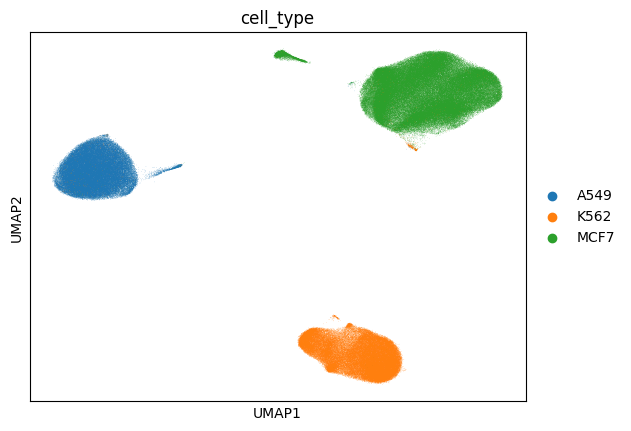

In [349]:
sc.pl.umap(adata, color="cell_type")

/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


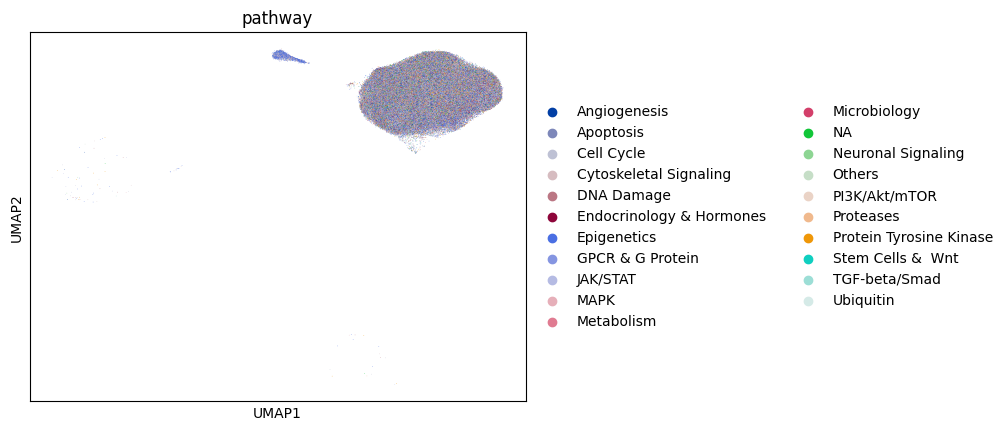

In [350]:
sc.pl.umap(adata[adata.obs.cell_type=="MCF7"], color="pathway")

In [351]:
adata.obs.cov_drug.value_counts()

MCF7_control       6358
K562_control       3359
A549_control       3287
MCF7_ENMD-2076     1678
MCF7_Fasudil       1248
                   ... 
K562_Epothilone     161
K562_Patupilone     156
K562_CUDC-907       155
A549_YM155           97
MCF7_YM155           41
Name: cov_drug, Length: 564, dtype: int64

**Check how the forward diffusion process behaves with counts**

In [352]:
from celldreamer.models.diffusion.distributions import x0_to_xt
from celldreamer.models.diffusion.variance_scheduler.cosine import CosineScheduler 

In [368]:
var_scheduler = CosineScheduler(T=4000)

alphas_hat = var_scheduler.get_alpha_hat()
alphas = var_scheduler.get_alphas()
betas = var_scheduler.get_betas()
betas_hat = var_scheduler.get_betas_hat()

In [372]:
alphas_hat[-1]

tensor(0.0004)

In [354]:
adata_small = adata.copy()
sc.pp.subsample(adata_small, fraction=0.05)
# adata_small.X -= adata_small.X.mean(1)
# adata_small.X /= adata_small.X.std(1)
# adata_small = assemble_adata(adata_small.X.A, adata_small.obs)

In [359]:
adata_small.X.max()

4.8204436

/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


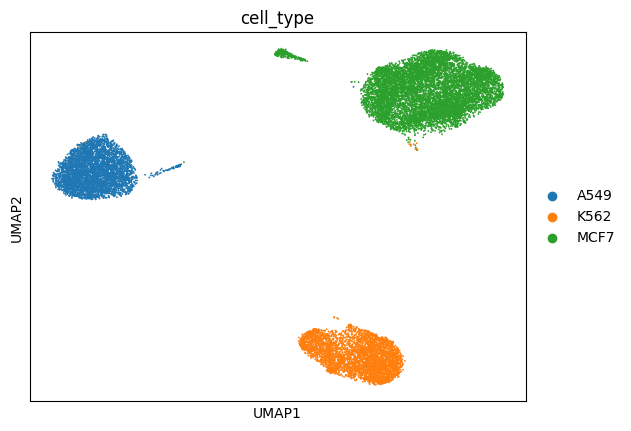

In [338]:
sc.pl.umap(adata_small, color="cell_type")

In [360]:
X = torch.tensor(adata_small.X.A)
eps = torch.rand_like(X)
X_t = x0_to_xt(X, alphas_hat[-1], eps)  

In [361]:
X_t.max()

tensor(1.0580)

In [362]:
adata_small_noise = assemble_adata(X_t.cpu().numpy(), adata_small.obs)

/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


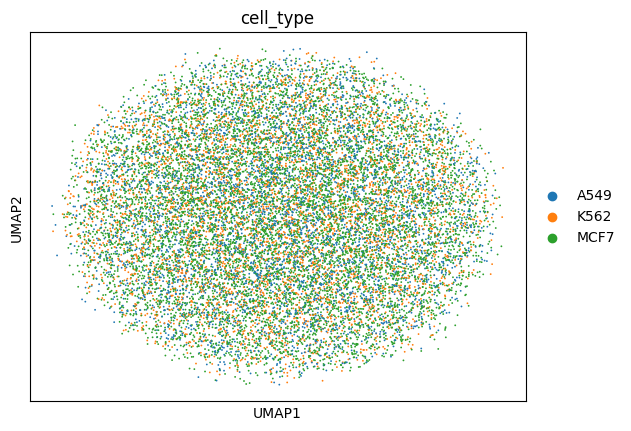

In [363]:
sc.pl.umap(adata_small_noise, color="cell_type")

**Check if obtained counts are Gaussian**

In [364]:
# Generate random noise 
X_eps = np.random.rand(adata_small.X.shape[0], adata_small.X.shape[1])

In [365]:
X_noise_real_generated = np.vstack([adata_small_noise.X, X_eps])
noise_label = ["fake_noise"]*adata_small_noise.X.shape[0] + ["real_noise"]*adata_small_noise.X.shape[0]
obs_noise_stack = pd.DataFrame({"noise_label":noise_label})

In [366]:
adata_small_noise_real_generated = assemble_adata(X_noise_real_generated, obs_noise_stack)

/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


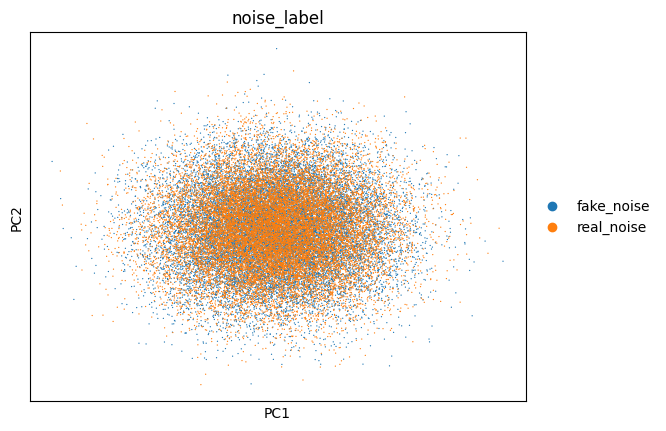

In [367]:
sc.pl.pca(adata_small_noise_real_generated, color="noise_label")

**Check results of a diffusion model**

In [15]:
import yaml
from celldreamer.data.utils import Args
from celldreamer.estimator.celldreamer_estimator import CellDreamerEstimator

In [16]:
file_path = '/nfs/homedirs/pala/celldreamer/configs/perturbation_modelling/config_ddpm.yaml'

# Open the file and load its contents
with open(file_path, 'r') as file:
    config_dict = Args(yaml.safe_load(file)["args"])

In [23]:
estimator = CellDreamerEstimator(config_dict)

datasets/sciplex/sciplex_complete_middle_subset.h5ad
Create the training folders...
Initialize data module...
datasets/sciplex/sciplex_complete_middle_subset.h5ad
datasets/sciplex/sciplex_complete_middle_subset.h5ad


/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logge

/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python3.10 /nfs/homedirs/pala/miniconda3/envs/celldreamer/l ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Initialize feature embeddings...
Initialize model...


In [24]:
state_dict = torch.load("/nfs/students/pala/celldreamer/try_experiment/checkpoints/last-v5.ckpt")['state_dict']
estimator.generative_model.load_state_dict(state_dict)

<All keys matched successfully>

In [25]:
batch = next(iter(estimator.datamodule.valid_dataloader))
y = estimator.generative_model._featurize_batch_y(batch)

/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [26]:
obs = pd.DataFrame(y[:100].argmax(1).numpy()).astype("category")
obs.columns = ["cell_type"]

In [27]:
with torch.no_grad():    
    gen = estimator.generative_model.generate(batch_size = 100, 
                                         y= y[:100], 
                                         z_t = None,
                                         T = 1000,
                                         get_intermediate_steps = False)

/nfs/homedirs/pala/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
